In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import List

In [234]:
@dataclass
class Handshake:
    start: float
    end: float
    start_ms: float
    end_ms: float

    @property
    def diff(self):
        return self.end_ms - self.start_ms

class DataLoader:
    csv_files_otii = {
        "current": "Main current - Arc.csv",
        "power": "Main power - Arc.csv",
        "gpio": "GPI 1 - Arc.csv",
    }

    def find_handshakes(df):
        # convert NaN to an arbitrary integer
        df['gpio'] = df['gpio'].fillna(-9).astype(int)

        gpio_values = df['gpio'].values
        in_handshake = False
        hs_start, hs_end = 0, 0
        handshake_indexes = []
        for index, value in enumerate(gpio_values):
            if not in_handshake and value == 1:
                in_handshake = True
                hs_start = index
            elif in_handshake and value == 0:
                in_handshake = False
                hs_end = index
                handshake_indexes.append(Handshake(hs_start, hs_end, df['Timestamp'].iloc[hs_start], df['Timestamp'].iloc[hs_end]))

            if in_handshake:
                gpio_values[index] = 1

        # convert temporary value to 0
        gpio_values[gpio_values == -9] = 0
        # Update the 'gpio' column in the DataFrame
        df['gpio'] = gpio_values
        return df, handshake_indexes

    def run(results_dir):
        dfs = []

        for source, csv_file in DataLoader.csv_files_otii.items():
            filename = f"{results_dir}/{csv_file}"
            df = pd.read_csv(filename)
            df = df.rename(columns={'Value': source})
            # print(df.head())
            dfs.append(df)

        merged_df = dfs[0]
        for df in dfs[1:]:
            merged_df = merged_df.merge(df, on="Timestamp", how="outer")

        # merged_df['gpio'] = fill_handshake_duration_with_1(merged_df['gpio'])
        merged_df, handshake_indexes = DataLoader.find_handshakes(merged_df)

        return merged_df, handshake_indexes

@dataclass
class HandshakeSet:
    csv_folder: str
    df: pd.DataFrame = field(default_factory=pd.DataFrame)
    handshakes: list = field(default_factory=list)

    def __post_init__(self):
        self.df, self.handshakes = DataLoader.run(self.csv_folder)

    def get_handshake(self, index, offset=0):
        return self.df.iloc[self.handshakes[index].start-offset : self.handshakes[index].end+offset]

    def __getitem__(self, index):
        return self.get_handshake(index)

edhoc = HandshakeSet("./results/edhoc-09aug-16h24-csv")
edhoc.get_handshake(0, offset=2)

,Timestamp,current,power,gpio
37046,9.26150,0.008858,0.029086,0
37047,9.26175,0.008834,0.029046,0
37048,9.26200,0.008804,0.028946,1
37049,9.26225,0.008775,0.028731,1
37050,9.26250,0.008753,0.028535,1
...,...,...,...,...
37777,9.44425,0.009386,0.030968,1
37778,9.44450,0.009389,0.030991,1
37779,9.44475,0.009389,0.031003,1
37780,9.44500,0.009370,0.030940,0


In [235]:
edhoc = HandshakeSet("./results/edhoc-09aug-16h24-csv")
dtls = HandshakeSet("./results/dtls-09aug-17h26-csv")

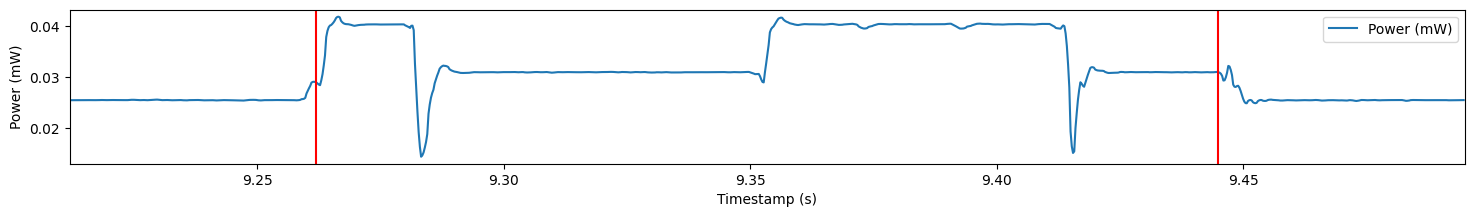

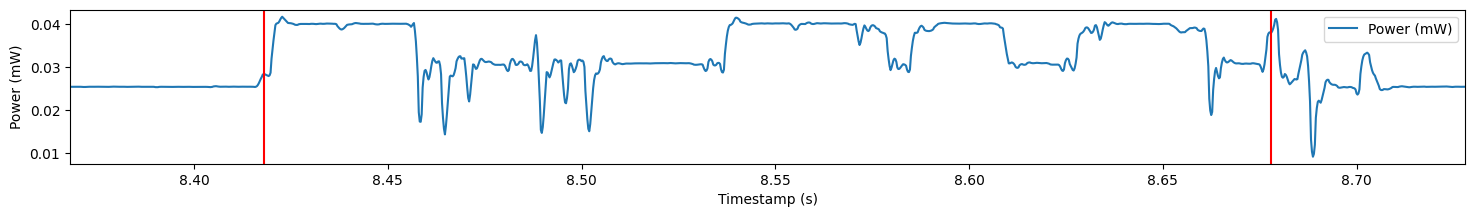

In [236]:
def plot_handshake(hs_set, index, hs_offset=200, xlim_offset=0.02):
    df = hs_set.get_handshake(index, hs_offset)
    plt.figure(figsize=(18, 2))
    plt.plot(df['Timestamp'], df['power'], label='Power (mW)')

    # # Draw vertical red lines at start and stop
    start_ms = hs_set.handshakes[index].start_ms
    end_ms = hs_set.handshakes[index].end_ms
    plt.xlim(start_ms - xlim_offset, end_ms + xlim_offset)
    plt.axvline(x=start_ms, color='red')
    plt.axvline(x=end_ms, color='red')

    plt.xlabel('Timestamp (s)')
    plt.ylabel('Power (mW)')

    plt.legend()
    plt.show()

plot_handshake(edhoc, 0, xlim_offset=0.05)
plot_handshake(dtls, 0, xlim_offset=0.05)